In [1]:
import numpy as np
import pickle
import time

from tqdm.auto import tqdm

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import GPy
import optunity as opt
import sobol as sb

import scipy.stats as stats


import matplotlib.pyplot as plt

In [2]:
retrain = True

# Data

In [3]:
with open('../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (192638, 28)
y_train.shape = (192638, 2)


# Preprocessing

# Parameter Optimization

In [4]:
SGDClassifier_parameters = {
    'n_jobs': 8,
    'fit_intercept': False, # data is scaled and centered, we can set fit_intercept=False
    'tol':1e-3,
    'shuffle': True,
    'random_state': 20210927
}

CalibratedClassifierCV_parameters = {
    'n_jobs': 8,
}

## Cross-Validation

In [5]:
def get_mean_CV_Score_hosp(score_function, hyperparameters):
    log_alpha, = hyperparameters

    kf = KFold(n_splits=5, shuffle=True, random_state=20210927)

    log_loss_list = np.empty(5, dtype=np.float64)

    for split_index, (fit_index, val_index) in enumerate(kf.split(X_train)):
        # create splits
        X_fit, X_val = X_train[fit_index], X_train[val_index]
        y_fit, y_val = y_train[fit_index], y_train[val_index]

        # scale features
        sc_X_fit = StandardScaler()
        X_fit_scaled = sc_X_fit.fit_transform(X_fit)
        X_val_scaled = sc_X_fit.transform(X_val)

        # create classifier
        base_svc_hosp = SGDClassifier(**SGDClassifier_parameters, alpha=np.exp(log_alpha))
        calibrated_svc_hosp = CalibratedClassifierCV(base_svc_hosp, **CalibratedClassifierCV_parameters)

        # fit
        calibrated_svc_hosp.fit(X_fit_scaled, y_fit[:, 0])

        # evaluate
        y_pred_proba = calibrated_svc_hosp.predict_proba(X_val_scaled)
        log_loss_list[split_index] = score_function(y_val[:, 0], y_pred_proba[:, 1])

    return np.mean(log_loss_list)

In [6]:
hyperparameter_search_space_boundaries = {
    'log_alpha': [-6, 6], # logarithm of the regularization coefficient
}

In [7]:
def expected_improvement(log_alpha):
    # compute E(q) and Var(q)
    # 
    E_pred, Var_pred = GP.predict_noiseless(np.array([[log_alpha]]))

    # compute gamma with the STD(q)
    γ = (E_best - E_pred) / np.sqrt(Var_pred)

    # return Expected Improvement
    return Var_pred * (γ * stats.norm.cdf(γ) + stats.norm.pdf(γ))

In [8]:
def initialize_GP(n_samples):
    Q_init = np.empty((n_samples, 1))
    E_init = np.empty((n_samples, 1))

    for i in range(n_samples):
        Q_init[i, :] = sb.i4_sobol(1, i)[0] * (hyperparameter_search_space_boundaries['log_alpha'][1] - hyperparameter_search_space_boundaries['log_alpha'][0]) + hyperparameter_search_space_boundaries['log_alpha'][0]

    for i, log_alpha in enumerate(tqdm(Q_init)):
        E_init[i, :] = get_mean_CV_Score_hosp(log_loss, (log_alpha,))

    return Q_init, E_init

In [9]:
initial_n_samples = 16
additional_n_samples = 64

In [10]:
if retrain:
    print('Initializing GP...')
    time.sleep(0.3)
    Q, E = initialize_GP(initial_n_samples)

    print('Training GP...')
    time.sleep(0.3)
    for k in tqdm(range(additional_n_samples)):

        # train Gaussian Process
        GP = GPy.models.GPRegression(Q, E, kernel=GPy.kern.Matern52(1))
        GP.optimize(messages=False)

        # determine E_best (minimum value of E)
        E_best = np.min(E)

        # determine q_new (q with maximum expected improvement)
        optimizer_output = opt.maximize(expected_improvement, log_alpha=hyperparameter_search_space_boundaries['log_alpha'])[0]
        q_new = np.array([optimizer_output['log_alpha']]).ravel()

        # add q_new to the training set Q
        Q = np.vstack((Q, q_new))

        # add COR(tau, sigma, gamma) to E
        E = np.vstack((E, get_mean_CV_Score_hosp(log_loss, q_new).reshape(-1, 1)))

    print('Completed Training')
    print('Storing Results...')
    with open('../results/SVC.pt', 'wb') as file:
        pickle.dump((Q, E), file)

    print('Stored Results...')
else:
    print('Loading Results...')
    with open('../results/SVC.pt', 'rb') as file:
        Q, E = pickle.load(file)
    print('Loaded Results')

GP = GPy.models.GPRegression(Q, E, kernel=GPy.kern.Matern52(1))
GP.optimize(messages=False);

Initializing GP...


100%|██████████| 16/16 [00:59<00:00,  3.73s/it]


Training GP...


100%|██████████| 64/64 [03:48<00:00,  3.56s/it]

Completed Training
Storing Results...
Stored Results...


### Hyperparameter Range

In [11]:
log_alpha_linspace = np.linspace(*hyperparameter_search_space_boundaries['log_alpha'], 1000)
GP_predicted_log_loss_mean, GP_predicted_log_loss_var = GP.predict_noiseless(log_alpha_linspace.reshape(-1, 1))
GP_predicted_log_loss_std = np.sqrt(GP_predicted_log_loss_var)

### Find 'Best' Hyperparameter

In [ ]:
def GP_log_loss_upper_confidence_bound(log_alpha):
    mean, var = GP.predict_noiseless(np.array([[log_alpha]]))
    return mean + np.std(var)

In [19]:
GP_best_hyperparameter_prediction = opt.minimize(GP_log_loss_upper_confidence_bound, log_alpha=hyperparameter_search_space_boundaries['log_alpha'])[0]

hyperparameter_best_upper_confidence_bound = {
    'alpha': np.exp(GP_best_hyperparameter_prediction['log_alpha'])
}

### Results

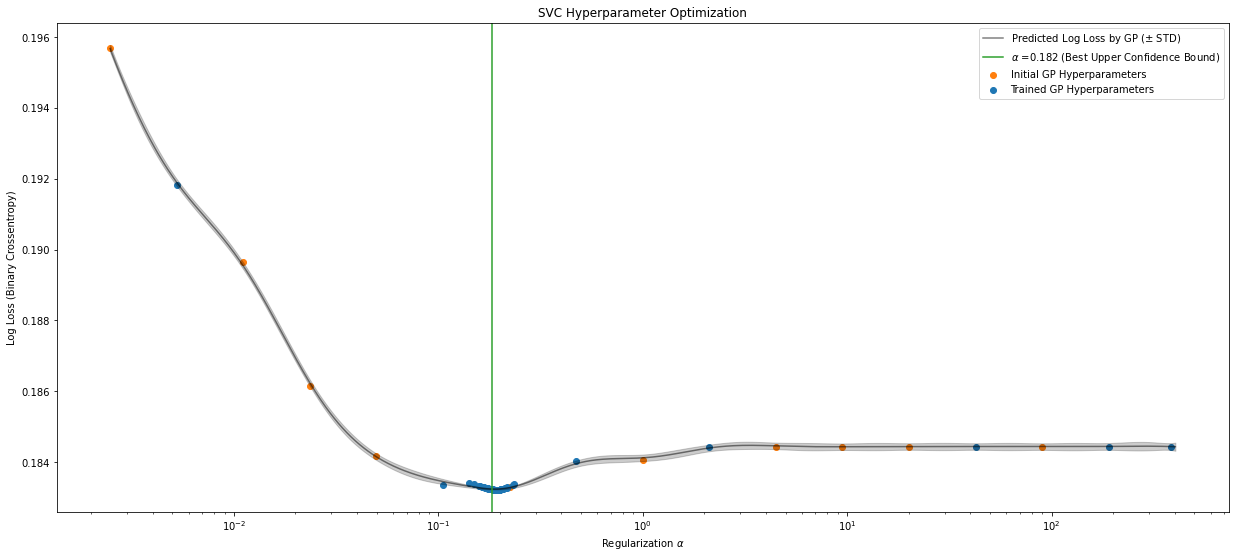

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(21, 9))
plt.scatter(np.exp(Q[:10, 0]), E[:10, 0], color='tab:orange', label='Initial GP Hyperparameters')
plt.scatter(np.exp(Q[10:, 0]), E[10:, 0], color='tab:blue', label='Trained GP Hyperparameters')

ax.plot(np.exp(log_alpha_linspace), GP_predicted_log_loss_mean[:, 0], color='black', alpha=0.5, label=r'Predicted Log Loss by GP ($\pm$ STD)')
ax.fill_between(np.exp(log_alpha_linspace), GP_predicted_log_loss_mean[:, 0] - GP_predicted_log_loss_std[:, 0], GP_predicted_log_loss_mean[:, 0] + GP_predicted_log_loss_std[:, 0], color='black', alpha=0.2)

ax.axvline(hyperparameter_best_upper_confidence_bound['alpha'], color='tab:green', label=r'$\alpha$ =' + f'{np.round(hyperparameter_best_upper_confidence_bound["alpha"], 3)} (Best Upper Confidence Bound)')

ax.set_xscale('log')
ax.set_xlabel(r'Regularization $\alpha$'); ax.set_ylabel('Log Loss (Binary Crossentropy)'); ax.set_title('SVC Hyperparameter Optimization')
ax.legend();

# Training

In [24]:
# scale features
sc_X_train = StandardScaler()
X_train_scaled = sc_X_train.fit_transform(X_train)

# create classifier
base_svc_hosp = SGDClassifier(**SGDClassifier_parameters, alpha=hyperparameter_best_upper_confidence_bound['alpha'])
calibrated_svc_hosp = CalibratedClassifierCV(base_svc_hosp, **CalibratedClassifierCV_parameters)

# fit
calibrated_svc_hosp.fit(X_train_scaled, y_train[:, 0]);

# Evaluation on Test Set

In [28]:
with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test_scaled = sc_X_train.transform(X_test)

X_test.shape = (48160, 28)
y_test.shape = (48160, 2)


In [31]:
y_pred_hosp_proba = calibrated_svc_hosp.predict_proba(X_test_scaled)
y_pred_hosp = calibrated_svc_hosp.predict(X_test_scaled)

print(f'binary cross-entropy: {log_loss(y_test[:, 0], y_pred_hosp_proba[:, 1])}')
print(f'brier loss: {brier_score_loss(y_test[:, 0], y_pred_hosp_proba[:, 1]).round(4)}')
print(f'accuracy: {accuracy_score(y_test[:, 0], y_pred_hosp).round(4)}')
print('confusion matrix:')
print(confusion_matrix(y_test[:, 0], y_pred_hosp))

binary cross-entropy: 0.18836639345603026
brier loss: 0.0489
accuracy: 0.9442
confusion matrix:
[[45453     9]
 [ 2678    20]]
